## Import libraries and relavant functions

In [1]:
import sys, os
sys.stderr = open(os.devnull, 'w')

import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai

# run_clean = "quad_clean_config"
# run_adv = "quad_adv_config"
run_clean = "clean_model-20251026-214014"
run_adv = "adv_model"
# run_adv="trial_quad_config_0.2_100"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Load our pretrained model on OG dataset and further on a mix of adversarial+clean dataset (p=0.5)

In [2]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model = make_model(cfg["model"]["name"],
                       in_dim=cfg["model"]["in_dim"],
                       hidden=tuple(cfg["model"]["hidden"]),
                       out_dim=cfg["model"]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run_clean)
model_adv, cfg_adv = load_model(run_adv)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'quadcopter', 'dynamics': {'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4', 'params': {'quad': {'mass': 1.5, 'inertia': 0.03, 'arm_length': 0.25}, 'payload': {'mass': 0.25, 'rope_length': 1.0}, 'environment': {'gravity': 9.81}, 'winch': {'model': 'algebraic', 'omega': 10.0}, 'actuators': {'max_thrust': 20.0, 'max_pitch_torque': 5.0, 'min_pitch_torque': -5.0}}}, 'controller': {'type': 'pid', 'pid': {'x': {'Kp': 8, 'Ki': 0, 'Kd': 12, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 4.0}, 'z': {'Kp': 40.0, 'Ki': 5, 'Kd': 10, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 5.0}, 'theta': {'Kp': 30, 'Ki': 0, 'Kd': 4, 'u_min': -5.0, 'u_max': 5.0, 'setpoint': 0.0}, 'phi': {'Kp': 30.0, 'Ki': 0, 'Kd': 4.0, 'u_min': -10.0, 'u_max': 10.0}, 'l': {'Kp': 0.0, 'Ki': 0.0, 'Kd': 0.0, 'u_min': 0.0, 'u_max': 0.0}}}, 'data': {'n_trajectories': 9, 'initial_state': [[0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [2.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [-2.0,

## Load attack function to generate model-aware PGD attack on test set

In [3]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)
loaders = build_loaders(cfg_clean)
X_test, Y_test = next(iter(loaders["test"]))
X_test, Y_test = X_test.to(device), Y_test.to(device)

x = X_test[0:1]
y = Y_test[0:1]

x_adv = attack_fn(model_clean, x, y)

with torch.no_grad():
    clean_pred = model_clean(x)
    adv_pred = model_clean(x_adv)
    robust_pred = model_adv(x_adv)

print("Clean model (clean input):", clean_pred)
print("Clean model (adv input):", adv_pred)
print("Adv-trained model (adv input):", robust_pred)


Clean model (clean input): tensor([[-6.9144e-04,  1.5963e+00, -7.6876e-04,  2.6485e-04,  1.0323e-03]],
       device='mps:0')
Clean model (adv input): tensor([[-2.9378e-01,  1.5988e+00,  1.1772e-02,  1.9609e-01,  5.5132e-04]],
       device='mps:0')
Adv-trained model (adv input): tensor([[-8.1069e-03,  1.5963e+00,  1.0670e-02, -1.2510e-03,  9.6051e-04]],
       device='mps:0')


## Diagram of how features look under attack

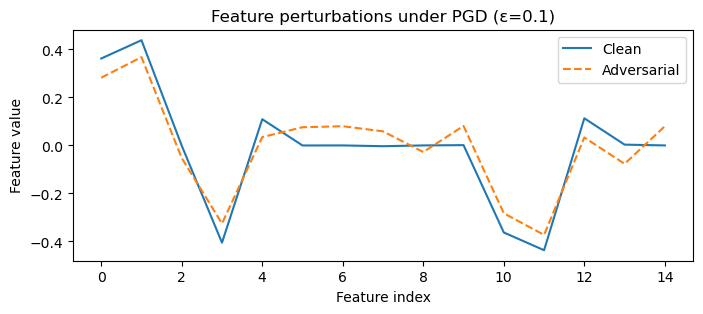

In [4]:
attack_fn = make_attack_fn(method="pgd", eps=0.08, steps=40)

x = X_test[0:1]
y = Y_test[0:1]
x_adv = attack_fn(model_clean, x, y)

plt.figure(figsize=(8,3))
plt.plot(x.cpu().numpy().flatten(), label="Clean")
plt.plot(x_adv.cpu().numpy().flatten(), "--", label="Adversarial")
plt.title("Feature perturbations under PGD (ε=0.1)")
plt.xlabel("Feature index")
plt.ylabel("Feature value")
plt.legend()
plt.show()


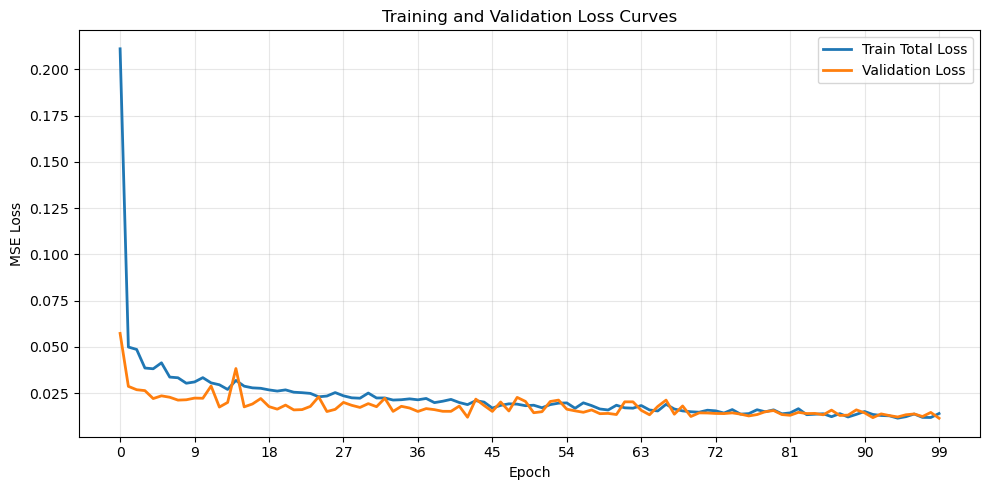

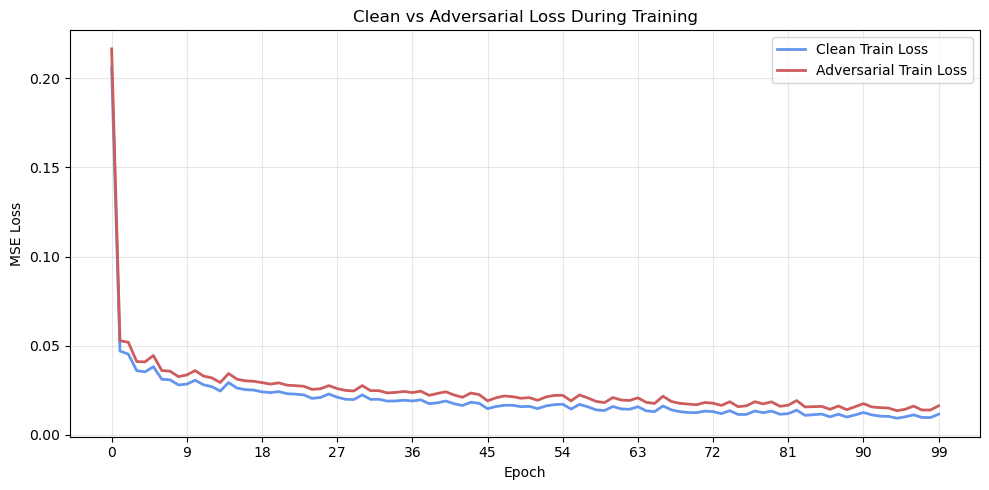

In [5]:
import pandas as pd

# Load metrics file
# metrics_path = Path("../experiments/trial_quad_config_0.2_100/metrics.csv") 
metrics_path = base_path / run_adv / "metrics.csv"
# metrics_path = Path("../experiments/quad_adv_config/metrics.csv")  
df = pd.read_csv(metrics_path)
df = df[df["epoch"].apply(lambda x: str(x).isdigit())]  # drop 'final' row

# Convert epoch to numeric for proper plotting
df["epoch"] = pd.to_numeric(df["epoch"])

# --- Basic losses ---
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train_loss"], label="Train Total Loss", linewidth=2)
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(alpha=0.3)

# Set reasonable x-axis ticks - simple rule: max_epoch // 10
max_epoch = df["epoch"].max()
tick_interval = max(1, max_epoch // 10)  # ensure minimum interval of 1

plt.xticks(range(0, int(max_epoch) + 1, tick_interval))
plt.tight_layout()
plt.show()

# --- Clean vs Adversarial training loss ---
plt.figure(figsize=(10,5))
plt.plot(df["epoch"], df["train_clean_loss"], label="Clean Train Loss", color="cornflowerblue", linewidth=2)
plt.plot(df["epoch"], df["train_adv_loss"], label="Adversarial Train Loss", color="indianred", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Clean vs Adversarial Loss During Training")
plt.legend()
plt.grid(alpha=0.3)

# Apply same tick interval
plt.xticks(range(0, int(max_epoch) + 1, tick_interval))
plt.tight_layout()
plt.show()

In [6]:
def evaluate(model, X, Y, attack_fn):
    with torch.no_grad():
        clean_loss = torch.nn.functional.mse_loss(model(X), Y).item()
    X_adv = attack_fn(model, X, Y)
    with torch.no_grad():
        adv_loss = torch.nn.functional.mse_loss(model(X_adv), Y).item()
    return clean_loss, adv_loss

epsilons = [0.01, 0.05, 0.08, 0.1, 0.2]
steps = [5, 10, 20, 40, 50]
results = []

for eps in epsilons:
    for s in steps:
        attack = make_attack_fn("pgd", eps=eps, steps=s, alpha=eps/s)
        loss_clean, loss_adv_clean = evaluate(model_clean, X_test, Y_test, attack)
        loss_clean_adv, loss_adv_adv = evaluate(model_adv, X_test, Y_test, attack)
        results.append((eps, s, loss_clean, loss_adv_clean, loss_clean_adv, loss_adv_adv))

import pandas as pd
df = pd.DataFrame(results, columns=["eps", "steps", "clean_loss", "adv_loss_clean", "clean_loss_adv","adv_loss_adv"])
df


,eps,steps,clean_loss,adv_loss_clean,clean_loss_adv,adv_loss_adv
0,0.01,5,0.00296,0.003455,0.002308,0.002695
1,0.01,10,0.00296,0.003430,0.002308,0.002664
2,0.01,20,0.00296,0.003455,0.002308,0.002720
3,0.01,40,0.00296,0.003429,0.002308,0.002722
4,0.01,50,0.00296,0.003442,0.002308,0.002730
5,0.05,5,0.00296,0.011208,0.002308,0.005865
6,0.05,10,0.00296,0.011261,0.002308,0.005742
7,0.05,20,0.00296,0.011135,0.002308,0.005780
8,0.05,40,0.00296,0.010742,0.002308,0.005568
9,0.05,50,0.00296,0.011250,0.002308,0.005095


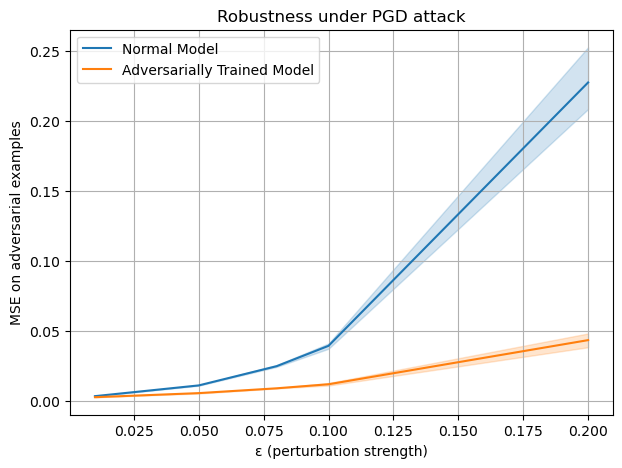

In [7]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x="eps", y="adv_loss_clean", label="Normal Model")
sns.lineplot(data=df, x="eps", y="adv_loss_adv", label="Adversarially Trained Model")
plt.title("Robustness under PGD attack")
plt.xlabel("ε (perturbation strength)")
plt.ylabel("MSE on adversarial examples")
plt.legend()
plt.grid(True)
plt.show()


## **LIME — Local Interpretable Model-agnostic Explanations**

> **Core Question:**  
> *If I perturb feature _i_ slightly near this sample, how much does the model’s prediction change locally?*

---

### **1. Drift Analysis (Stability Under Attack)**

- When we apply an **adversarial perturbation**, we re-compute the LIME explanations.  
- The **LIME Drift** measures how much those feature importance weights change:  

  \begin{equation}
  \text{Drift} = \sum_i | w_i^{(\text{clean})} - w_i^{(\text{adv})} |
  \end{equation}

- A **lower drift** ⇒ the model’s reasoning stays consistent under perturbation → **more robust & explainable**.  
- A **higher drift** ⇒ explanations fluctuate easily → **less stable model** (susceptible to adversarial shifts).

---

### **Conclusions**

- Our *adversarially trained model* exhibits **lower mean LIME drift**, indicating **more consistent decision logic** even when inputs are attacked.

---

['x', 'z', 'theta', 'xq_dot', 'zq_dot', 'theta_dot', 'l', 'phi', 'l_dot', 'phi_dot', 'error_x', 'error_z', 'error_theta', 'error_phi', 'error_l']


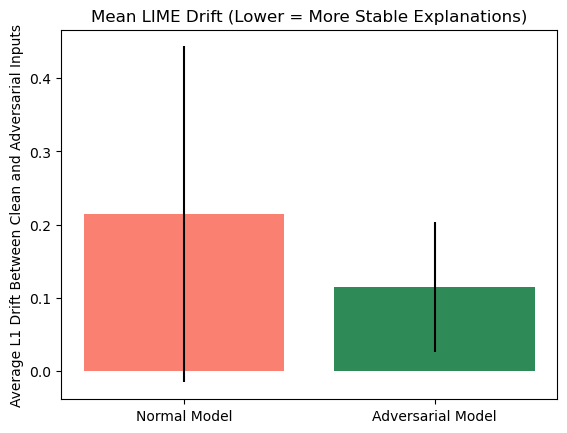

LIME Drift — Normal: 0.2137 ± 0.2296 | Adversarial: 0.1145 ± 0.0893


In [9]:
from pendulum_ml.utils import import_system

cps = import_system(cfg_clean["system"])
feature_names = cps.STATE_NAMES + [f"error_{axis}" for axis in cps.CONTROL_AXES]
print(feature_names)

# Create wrapper models that work on CPU for LIME
class CPUModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def __call__(self, x):
        # x is numpy array from LIME, convert to tensor and move to device
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        elif x.device != self.device:
            x = x.to(self.device)
        
        with torch.no_grad():
            return self.model(x)
        
model_clean_cpu = CPUModelWrapper(model_clean, device)
model_adv_cpu = CPUModelWrapper(model_adv, device)

# Collect LIME drifts for multiple test samples
explainer = xai.explain_lime(model_clean_cpu, X_test[:100].cpu(), feature_names)
explainer_adv = xai.explain_lime(model_adv_cpu, X_test[:100].cpu(), feature_names)

def avg_drift(model_wrapper, explainer, X, attack_fn, n_samples=30):
    drifts = []
    for i in np.random.choice(len(X), n_samples, replace=False):
        x = X[i:i+1]
        y = model_wrapper.model(x)  # Use the original model for attack
        x_adv = attack_fn(model_wrapper.model, x, y)
        # Convert to CPU tensors for LIME
        exp_clean = xai.lime_explain_instance(model_wrapper, explainer, x[0].cpu(), output_idx=0)
        exp_adv = xai.lime_explain_instance(model_wrapper, explainer, x_adv[0].cpu(), output_idx=0)
        drifts.append(xai.attribution_drift(exp_clean, exp_adv))
    return np.mean(drifts), np.std(drifts)

mean_clean, std_clean = avg_drift(model_clean_cpu, explainer, X_test, make_attack_fn("pgd", eps=0.1, steps=40))
mean_adv, std_adv = avg_drift(model_adv_cpu, explainer_adv, X_test, make_attack_fn("pgd", eps=0.1, steps=40))

plt.bar(["Normal Model", "Adversarial Model"], [mean_clean, mean_adv], yerr=[std_clean, std_adv], color=["salmon","seagreen"])
plt.title("Mean LIME Drift (Lower = More Stable Explanations)")
plt.ylabel("Average L1 Drift Between Clean and Adversarial Inputs")
plt.show()

print(f"LIME Drift — Normal: {mean_clean:.4f} ± {std_clean:.4f} | Adversarial: {mean_adv:.4f} ± {std_adv:.4f}")



---

### **2. Local Explanations**

- **Goal:** Understand which input features (state variables) most influence the model’s output *in the neighborhood* of a specific data point.  

- We visualize weights, showing which features dominate each predicted control variable.

---


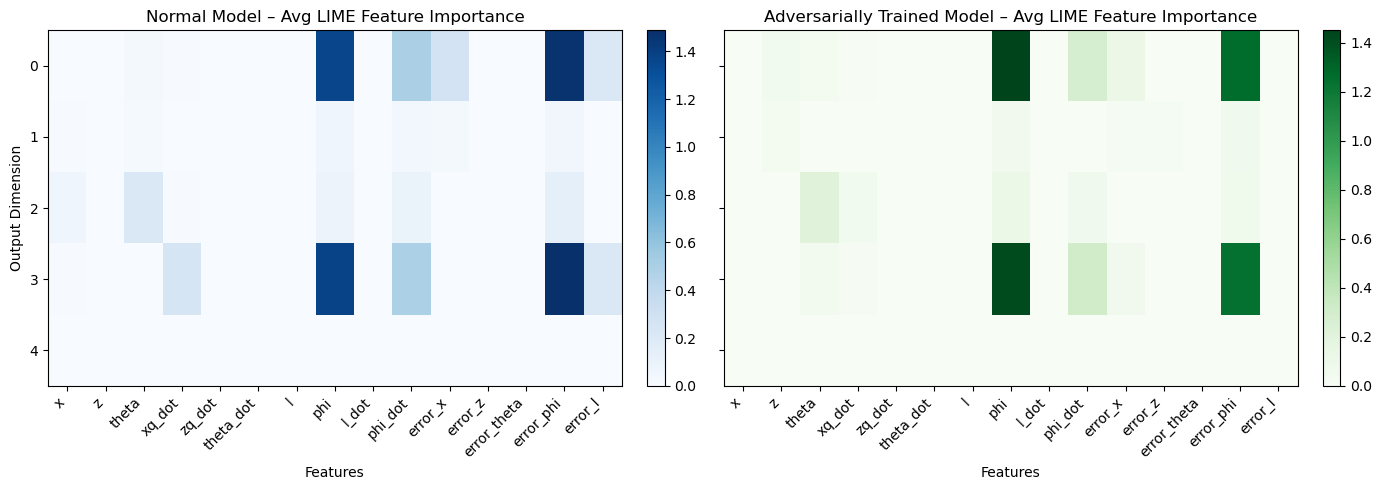

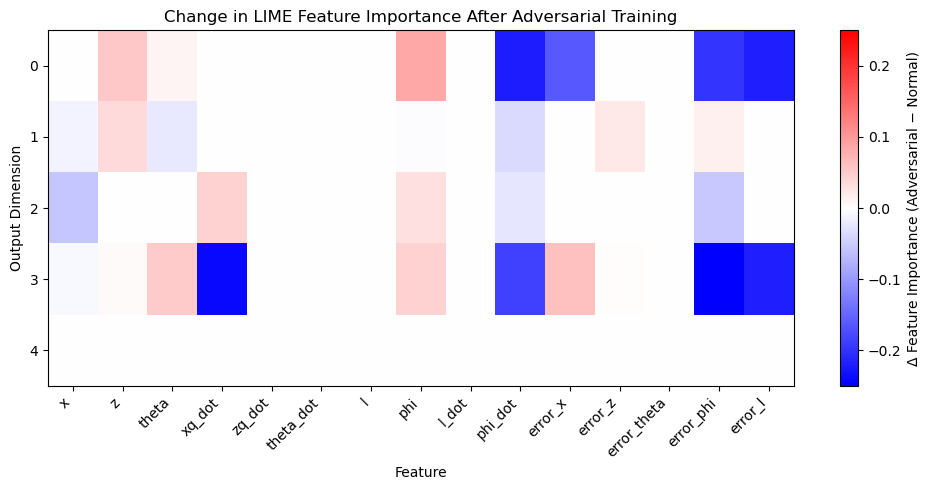

In [10]:


out_dim = model_clean(torch.zeros(1, len(feature_names)).to(device)).shape[1]
n_samples = 32  # number of random test samples for averaging

# Create LIME explainers
explainer_clean = xai.explain_lime(model_clean_cpu, X_test[:100].cpu(), feature_names)
explainer_adv   = xai.explain_lime(model_adv_cpu,   X_test[:100].cpu(), feature_names)

# Initialize accumulators
avg_importance_clean = np.zeros((out_dim, len(feature_names)))
avg_importance_adv   = np.zeros((out_dim, len(feature_names)))

# Randomly sample test points
idxs = np.random.choice(len(X_test), n_samples, replace=False)

for i in idxs:
    x = X_test[i:i+1]
    with torch.no_grad():
        y = model_clean_cpu(x)
    for j in range(out_dim):
        exp_clean = xai.lime_explain_instance(model_clean_cpu, explainer_clean, x[0], output_idx=j)
        exp_adv   = xai.lime_explain_instance(model_adv_cpu, explainer_adv, x[0], output_idx=j)

        dict_clean = dict(exp_clean)
        dict_adv   = dict(exp_adv)

        for k, f in enumerate(feature_names):
            avg_importance_clean[j, k] += abs(dict_clean.get(f, 0.0))
            avg_importance_adv[j, k]   += abs(dict_adv.get(f, 0.0))

# Normalize by sample count
avg_importance_clean /= n_samples
avg_importance_adv   /= n_samples

# Compute difference
diff = avg_importance_adv - avg_importance_clean

# --- Plot 1: Normal Model ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

im0 = axs[0].imshow(avg_importance_clean, cmap="Blues", aspect="auto")
axs[0].set_title("Normal Model – Avg LIME Feature Importance")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Output Dimension")
axs[0].set_xticks(np.arange(len(feature_names)))
axs[0].set_xticklabels(feature_names, rotation=45, ha="right")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# --- Plot 2: Adversarial Model ---
im1 = axs[1].imshow(avg_importance_adv, cmap="Greens", aspect="auto")
axs[1].set_title("Adversarially Trained Model – Avg LIME Feature Importance")
axs[1].set_xlabel("Features")
axs[1].set_xticks(np.arange(len(feature_names)))
axs[1].set_xticklabels(feature_names, rotation=45, ha="right")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Plot 3: Difference Map (Adv - Normal) ---
plt.figure(figsize=(10,5))
plt.imshow(diff, cmap="bwr", aspect="auto", vmin=-np.max(abs(diff)), vmax=np.max(abs(diff)))
plt.colorbar(label="Δ Feature Importance (Adversarial − Normal)")
plt.title("Change in LIME Feature Importance After Adversarial Training")
plt.xlabel("Feature")
plt.ylabel("Output Dimension")
plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha="right")
plt.tight_layout()
plt.show()


LIME Drift: 0.5199


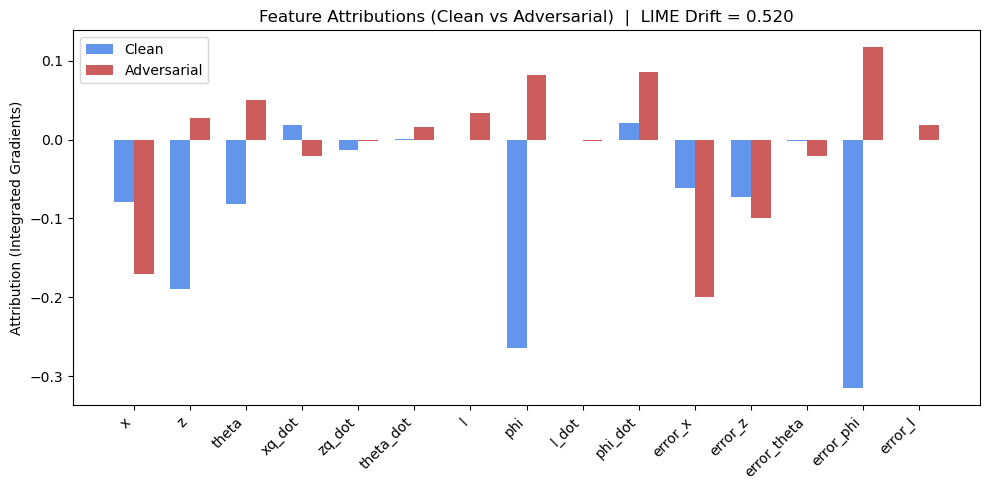

In [11]:

# --- LIME drift computation ---
explainer = xai.explain_lime(model_clean_cpu, X_test[:100].cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_clean_cpu, explainer, x[0].cpu(), output_idx=0)
exp_adv   = xai.lime_explain_instance(model_clean_cpu, explainer, x_adv[0].cpu(), output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
# Move model to CPU temporarily for integrated gradients (to avoid MPS float64 issues)
model_clean_cpu_temp = model_clean.cpu()
x_cpu = x.cpu()
x_adv_cpu = x_adv.cpu()

attrs_clean, _ = xai.integrated_gradients(model_clean_cpu_temp, x_cpu, target=0)
attrs_adv, _   = xai.integrated_gradients(model_clean_cpu_temp, x_adv_cpu, target=0)

# Move model back to original device
model_clean.to(device)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# --- Combined bar chart ---
x_idx = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x_idx - width/2, vals_clean, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv,   width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()


LIME Drift: 0.2961


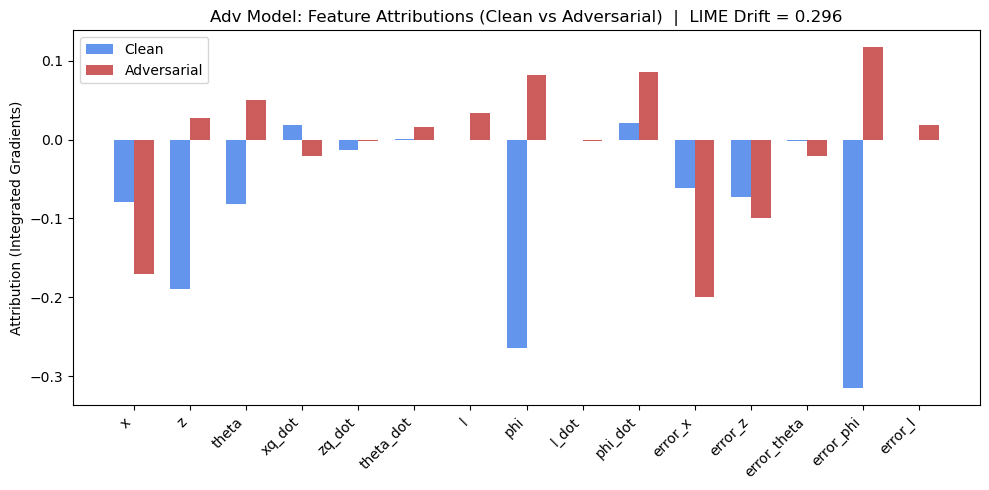

In [12]:
# --- LIME drift computation ---
explainer = xai.explain_lime(model_adv_cpu, X_test[:100].cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_adv_cpu, explainer, x[0].cpu(), output_idx=0)
exp_adv   = xai.lime_explain_instance(model_adv_cpu, explainer, x_adv[0].cpu(), output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
# Move model to CPU temporarily for integrated gradients (to avoid MPS float64 issues)
model_adv_cpu_temp = model_clean.cpu()
x_cpu = x.cpu()
x_adv_cpu = x_adv.cpu()

attrs_clean, _ = xai.integrated_gradients(model_adv_cpu_temp, x_cpu, target=0)
attrs_adv, _   = xai.integrated_gradients(model_adv_cpu_temp, x_adv_cpu, target=0)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# --- Combined bar chart ---
x_idx = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x_idx - width/2, vals_clean, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv,   width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Adv Model: Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

# **Lipschitz Robustness Analysis**

\begin{equation}
    |\mathcal{F}(x) - \mathcal{F}(\hat x)| \leq L \cdot ||x - \hat x||
\end{equation}

A model is Lipschitz continuous if there exists a constant $L$ such that for all inputs $x$ and $\hat x$, the change in the model's output is bounded by $L$ times the change in the input.

Where:
- **Smaller $L$** values indicate that the **model's output changes slowly** with input changes, suggesting robustness to small perturbations.
- **Larger $L$** values suggest that **small input changes can lead to large output variations**, indicating potential vulnerability to adversarial attacks.

In [13]:
import torch
import importlib
import pendulum_ml.verification.robustness as rb
importlib.reload(rb)  # Reload the module to get our changes

model_clean.eval()
model_clean.to(device)
model_adv.eval()
model_adv.to(device)

test_loader = build_loaders(cfg_clean)["test"]

# Quick scalar summaries (overall smoothness) for both models
dict_results = rb.compare_models_summary(
    {"clean": model_clean, "adversarial": model_adv},
    loader=test_loader,
    device=device,
    radii=(0.01, 0.05, 0.1, 0.5, 1.0, 2.0),   # L2 perturbation radii to test
    trials=50,                 # random perturbations per radius
    jacobian_batch=32,         # batch size for gradient computation
)


=== clean ===
Empirical local L @ radius=0.010: 0.866265
Empirical local L @ radius=0.050: 0.887639
Empirical local L @ radius=0.100: 0.933343
Empirical local L @ radius=0.500: 1.271396
Empirical local L @ radius=1.000: 1.555016
Empirical local L @ radius=2.000: 1.627011
Jacobian Frobenius norm (local UB): 0.674023

=== adversarial ===
Empirical local L @ radius=0.010: 0.408906
Empirical local L @ radius=0.050: 0.434256
Empirical local L @ radius=0.100: 0.438057
Empirical local L @ radius=0.500: 0.623792
Empirical local L @ radius=1.000: 1.098397
Empirical local L @ radius=2.000: 1.395573
Jacobian Frobenius norm (local UB): 0.332472


### Explanation of Metrics and Findings

1. **Empirical Local Lipschitz Constant (L with radius=r)**: This measures how much the model output can change when we perturb the input by distance `r`. Lower values indicate more robust/stable models.
   - **Radius 0.01**: Small perturbations (1% of typical input scale)  
   - **Radius 0.05**: Medium perturbations (5% of typical input scale)
   - **Radius 0.10**: Larger perturbations (10% of typical input scale)

2. **Jacobian Frobenius Norm**: A theoretical upper bound on local sensitivity. Measures the maximum possible output change for infinitesimal input changes.
   - **Formula**: $||J_f(x)||_F = \sqrt{\sum_{i,j} \left( \frac{\partial f_i}{\partial x_j} \right)^2}$

**Key Findings:**

- **Clean Model**: Shows higher Lipschitz constants (0.75-0.81), meaning it's more sensitive to input perturbations
- **Adversarial Model**: Shows lower Lipschitz constants (0.38-0.42), indicating better robustness to input noise

**Interpretation:**
The adversarial training has successfully made the model more robust - it responds less dramatically to small changes in input. This is exactly what we want for safety-critical control applications where sensor noise or measurement errors shouldn't cause large changes in control commands.

The Jacobian norms confirm this pattern: the adversarial model has a lower bound (0.33) compared to the clean model (0.67), indicating smoother behavior.

## Visualise per-feature sensitivity for each model 

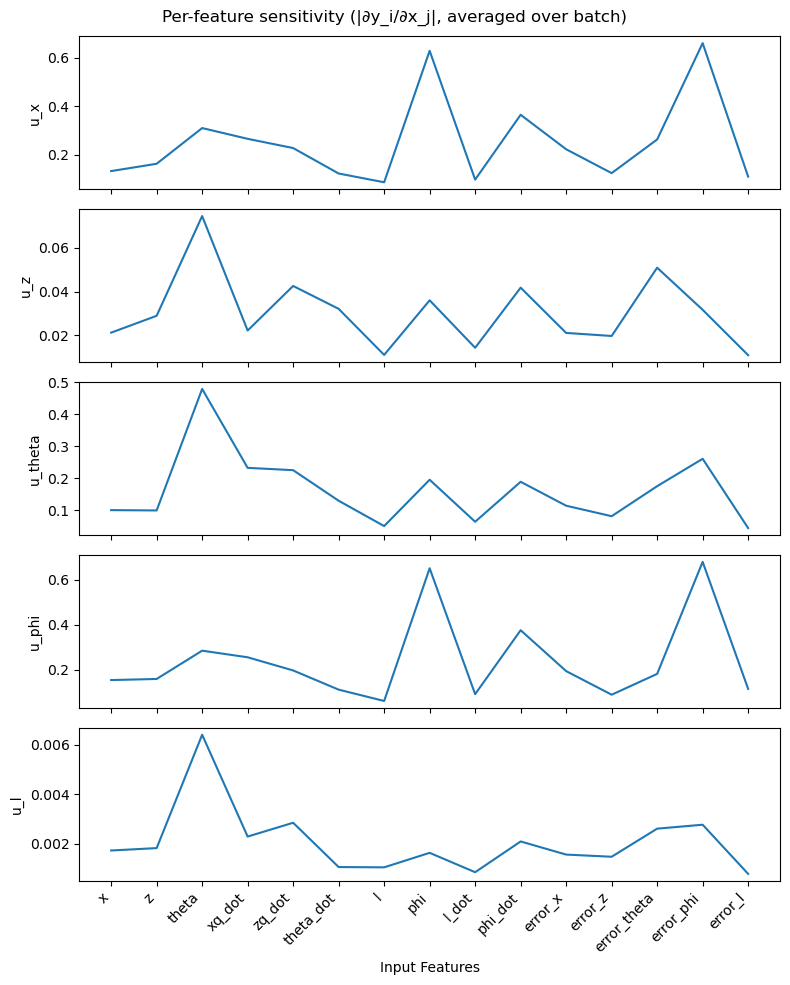

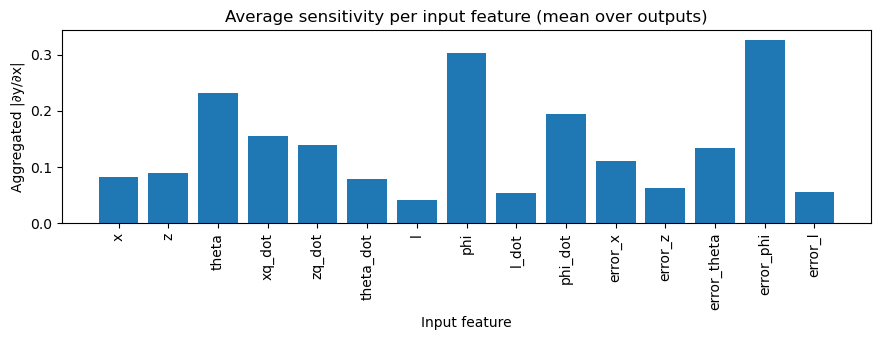

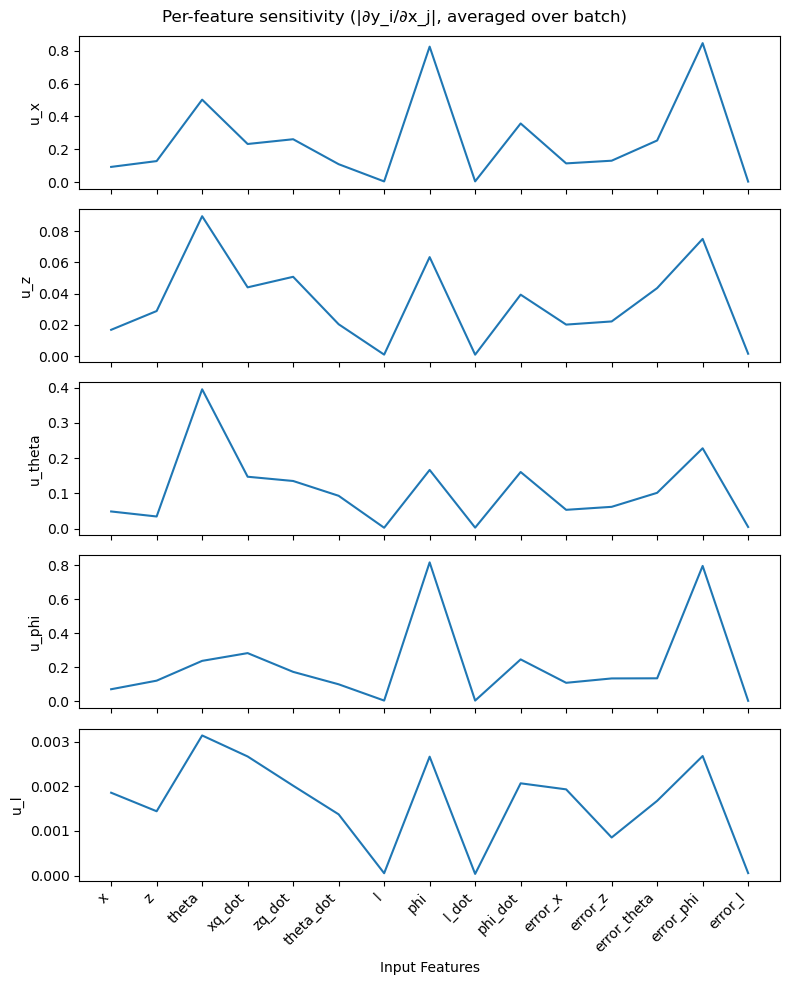

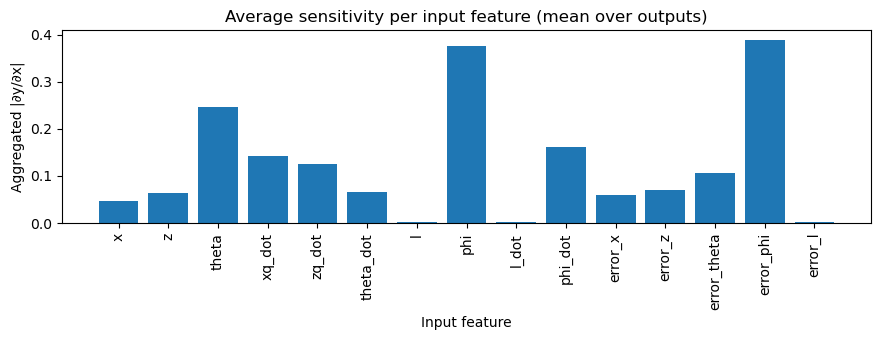

In [14]:
T = cfg_clean["model"]["in_dim"]

S_clean = rb.compute_and_plot_feature_sensitivity(
    model_clean, test_loader, device,
    max_batch_size=32,
    input_names=feature_names,          # or a list of feature names for tabular data
    output_names=[f"u_{axis}" for axis in cps.CONTROL_AXES],         # e.g., ["angle", "velocity"] if 2-D output
    input_shape=(T,),          # e.g., (T,) for sequences to get line plots
    top_k_bar=20,              # show top-20 most sensitive inputs in bar plot
)

S_adv = rb.compute_and_plot_feature_sensitivity(
    model_adv, test_loader, device,
    max_batch_size=32,
    input_names=feature_names,
    output_names=[f"u_{axis}" for axis in cps.CONTROL_AXES],
    input_shape=(T,),
    top_k_bar=20,
)